Zach Green, Project 3, 9/9/2018

## Imports

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

%matplotlib inline

In [2]:
# Let's see how long this takes to run
run_start = time.time()

# Prepare Data

In [3]:
# read the csv files
#     subreddits: history jokes science research

target_subred_df = pd.read_csv('science_posts.csv')
alt_subred_df = pd.read_csv('history_posts.csv')

In [4]:
# balance classes by removing extra posts in history (undersampling)
alt_subred_df = alt_subred_df.head(target_subred_df.shape[0])
alt_subred_df.shape

(666, 93)

In [5]:
# only include the columns we're interested in
target_subred_df = target_subred_df[['title', 'ups', 'downs', 'num_comments', 'selftext']]
alt_subred_df = alt_subred_df[['title', 'ups', 'downs', 'num_comments', 'selftext']]

# assign target variable
target_subred_df['is_target'] = 1
alt_subred_df['is_target'] = 0

In [6]:
# combine into one df
master_df = pd.concat([target_subred_df, alt_subred_df])
master_df.reset_index(drop=True, inplace=True)

# Tokenizing and Vectorizing

In [7]:
# make a list of all the words in the train set
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
title_lists = []

stemmer = PorterStemmer()

# loop through each title and stem
for title in master_df['title']:
    title_words =  tokenizer.tokenize(title.lower())
    title_str = ''
    for word in title_words:
        token = stemmer.stem(word)
        title_str = title_str + token + ' '
    title_lists.append(title_str)

token_col = pd.Series(title_lists)

In [8]:
# create X and y
X = token_col
y = master_df['is_target']

# train-test-split
text_X_train, text_X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [9]:
# who you callin' corpus
train_corpus = list(text_X_train)
test_corpus = list(text_X_test)

In [10]:
# Vectorize
vect = TfidfVectorizer(ngram_range=(1,3), max_features=1500, stop_words=['research'])
raw_vec_train = vect.fit_transform(train_corpus)
X_train = pd.DataFrame(raw_vec_train.toarray(), columns = vect.get_feature_names())

# Do the same thing for the test set
raw_vec_test = vect.transform(test_corpus)
X_test = pd.DataFrame(raw_vec_test.toarray(), columns = vect.get_feature_names())

# Functions <hr>

### Define Model Fitting Function

In [11]:
index_labels = ['Test score','Train score', 'Sensitivity', 'Specificity', 'Precision', 'Parameters']

all_results = pd.DataFrame(index=index_labels)
all_params = pd.DataFrame(columns = ['Parameters'])

# set dataframe options to display long strings rather than truncating them
pd.set_option('display.max_colwidth', 10000)

In [12]:
def fit_model(model, model_name, params, all_results, all_params):
    start_time = time.time()

    # fit
    model = GridSearchCV(model, params, n_jobs=-1, cv = 3)
    model.fit(X_train, y_train)
    
    # pick out the best model
    best_model = model.best_estimator_
    
    # make the confusion matrix
    pred = best_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    # Calculate results
    index_labels = ['Test score', 'Train score', 'Sensitivity', 'Specificity', 'Precision']
    result = pd.DataFrame(index = index_labels, columns=[model_name])
    result.loc['Test score'][model_name] = round(best_model.score(X_test, y_test), 3)
    result.loc['Train score'][model_name] = round(model.best_score_, 3)
    result.loc['Sensitivity'][model_name] = round(tp/(tp+fn), 3)
    result.loc['Specificity'][model_name] = round(tn/(tn+fp), 3)
    result.loc['Precision'][model_name] = round(tp/(tp+fp), 3)
    display(result)
    

    # add results and params to all_results and all_params
    all_results = pd.concat([all_results, result], axis=1)
    result_series = pd.Series({'Parameters' : model.best_params_}, name=model_name)
    all_params = all_params.append(result_series)
    display(all_params.loc[[model_name]])

    # Create the confusion matrix
    total = (tp + tn + fp + fn)
    confusion = pd.DataFrame(index= ['Pred. Positive','Pred. Negative', 'Total'])
    confusion['Act. Positive'] = str(round(tp/total*100, 1))+'%', str(round(fn/total*100, 1))+'%', (tp + fn)
    confusion['Act. Negative'] = str(round(fp/total*100, 1))+'%', str(round(tn/total*100, 1))+'%', (fp + tn)
    confusion['Total'] = (tp + fp), (fn + tn), total
    display(confusion)
    
    # print the runtime
    end_time = time.time()
    print('Runtime: ', round((end_time - start_time)/60, 3), ' minutes')
    return all_results, all_params, confusion, best_model

### ROC Curve Function

In [13]:
def make_roc(y_test, best_model):
# ROC-AUC curve

    # make predicted probabilities to be returned for use in the ROC Curve
    y_hat_proba = best_model.predict_proba(X_test)

    # Generate False positive rate and True positive rate
    fpr, tpr, _ = roc_curve(y_test, y_hat_proba[:,1])
    roc_auc = auc(fpr, tpr)

    # Plot 
    plt.figure(figsize=(6, 4))
    line_width = 4
    plt.title('ROC Curve', fontsize=25, position = (0.2,1))
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.grid(True)
    plt.plot(fpr, tpr, lw = line_width)
    plt.plot([0, 1], [0,1], lw = line_width, linestyle = '--')

# Models <hr>

## Naive Bayes

,Naive Bayes
Test score,0.919
Train score,0.885
Sensitivity,0.928
Specificity,0.91
Precision,0.912


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
Naive Bayes,{'priors': None}


,Act. Positive,Act. Negative,Total
Pred. Positive,46.5%,4.5%,170
Pred. Negative,3.6%,45.3%,163
Total,167,166,333


Runtime:  0.056  minutes


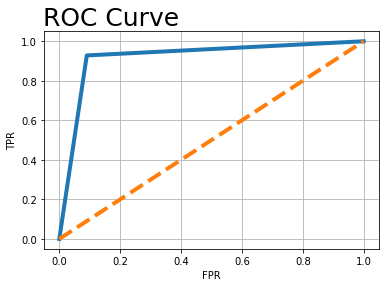

In [14]:
# Naive Bayes
#     GaussianNB() if tfidf
#     MultinomialNB() if countvec

# set parameters
nb_params = {'priors': [None]}

# call the fit_model function
all_results, all_params, confusion, nb_best_model = fit_model(GaussianNB(), 'Naive Bayes', nb_params, all_results, all_params)

# Plot ROC Curve with make_roc function
make_roc(y_test, nb_best_model)

## Logisitic regression

/Users/zachgreen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Logistic
Test score,0.928
Train score,0.926
Sensitivity,0.892
Specificity,0.964
Precision,0.961


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
Logistic,"{'C': 25, 'penalty': 'l2'}"


,Act. Positive,Act. Negative,Total
Pred. Positive,44.7%,1.8%,155
Pred. Negative,5.4%,48.0%,178
Total,167,166,333


Runtime:  0.036  minutes


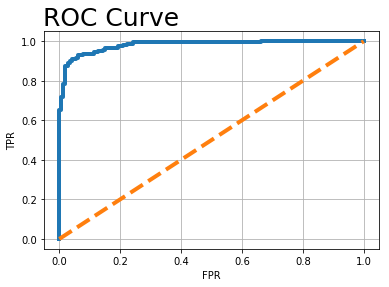

In [15]:
# Logisitic regression
lr_params = {
    'penalty': ['l2'],
    'C': [25]#[1, 10, 25, 40, 50, 60, 75, 90, 100, 250]
}

all_results, all_params, confusion, lr_best_model = fit_model(LogisticRegression(), 'Logistic', lr_params, all_results, all_params)

# Plot ROC Curve with make_roc function
make_roc(y_test, lr_best_model)

## Support Vector Machine

,SVM
Test score,0.931
Train score,0.931
Sensitivity,0.904
Specificity,0.958
Precision,0.956


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
SVM,"{'C': 1.2, 'kernel': 'linear'}"


,Act. Positive,Act. Negative,Total
Pred. Positive,45.3%,2.1%,158
Pred. Negative,4.8%,47.7%,175
Total,167,166,333


Runtime:  0.205  minutes


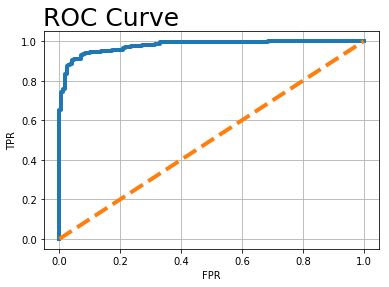

In [16]:
# SVM
svm_params = {
    'C': [1.2],#[1.1, 1.15, 1.2],
    'kernel': ['linear'],
}

all_results, all_params, confusion, svm_best_model = fit_model(svm.SVC(probability=True), 'SVM', svm_params, all_results, all_params)


# Plot ROC Curve with make_roc function
make_roc(y_test, svm_best_model)

## KNN

,KNN
Test score,0.886
Train score,0.883
Sensitivity,0.826
Specificity,0.946
Precision,0.939


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
KNN,"{'metric': 'minkowski', 'n_neighbors': 75, 'p': 2, 'weights': 'distance'}"


,Act. Positive,Act. Negative,Total
Pred. Positive,41.4%,2.7%,147
Pred. Negative,8.7%,47.1%,186
Total,167,166,333


Runtime:  0.097  minutes


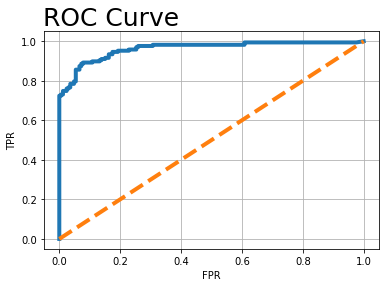

In [17]:
# KNN
knn_params = {
    'n_neighbors': [75],#[25, 40, 50, 75],
    'weights': ['distance'],
    'metric': ['minkowski'],
    'p': [2]#[1, 2, 3, 5] #p=1 and p=2 correspond to manhattan and euclidean distance equations respectively
}

all_results, all_params, confusion, knn_best_model = fit_model(KNeighborsClassifier(), 'KNN', knn_params, all_results, all_params)

# Plot ROC Curve with make_roc function
make_roc(y_test, knn_best_model)

## Random Forest

,Random Forest
Test score,0.883
Train score,0.881
Sensitivity,0.82
Specificity,0.946
Precision,0.938


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
Random Forest,"{'bootstrap': False, 'max_features': 46, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 75}"


,Act. Positive,Act. Negative,Total
Pred. Positive,41.1%,2.7%,146
Pred. Negative,9.0%,47.1%,187
Total,167,166,333


Runtime:  0.045  minutes


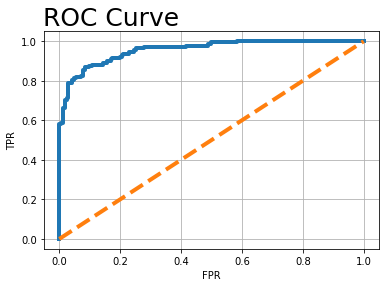

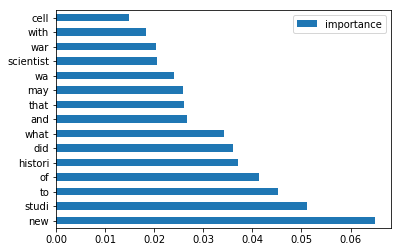

In [18]:
# Random Forest Model
rf_params = {
    'n_estimators': [75], #[60, 75, 90, 100, 125],
    'min_samples_split': [2],
    'min_samples_leaf': [3],
    'bootstrap': [False],
    'max_features': [46] #range(
#                         int(np.sqrt(len(X_train.columns)))-int(.5*np.sqrt(len(X_train.columns))), # .5 Lower bound
#                         int(np.sqrt(len(X_train.columns)))+int(.5*np.sqrt(len(X_train.columns))), # .5 Upper bound
#                         int(.25*np.sqrt(len(X_train.columns)))) # Step size: .25)
}

all_results, all_params, confusion, rf_best_model = fit_model(RandomForestClassifier(), 'Random Forest', rf_params, all_results, all_params)

# Plot ROC Curve with make_roc function
make_roc(y_test, rf_best_model)

# plot important features
feat_importance = pd.DataFrame(rf_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

## Extra Trees

,Extra Trees
Test score,0.925
Train score,0.892
Sensitivity,0.886
Specificity,0.964
Precision,0.961


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
Extra Trees,"{'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 75}"


,Act. Positive,Act. Negative,Total
Pred. Positive,44.4%,1.8%,154
Pred. Negative,5.7%,48.0%,179
Total,167,166,333


Runtime:  0.062  minutes


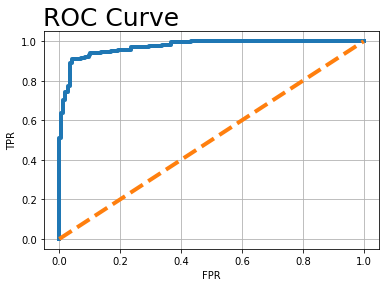

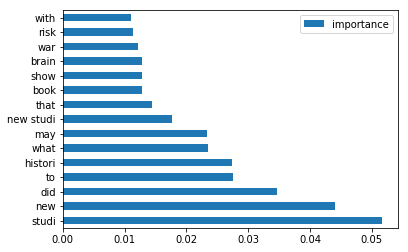

In [19]:
# Extra Trees
et_params = {
    'n_estimators': [75],#[50, 75, 100],
    'min_samples_split': [4],
    'min_samples_leaf': [3],
}

all_results, all_params, confusion, et_best_model = fit_model(ExtraTreesClassifier(), 'Extra Trees', et_params, all_results, all_params)

# Plot ROC Curve with make_roc function
make_roc(y_test, et_best_model)

# plot important features
feat_importance = pd.DataFrame(et_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

## Gradient Boost

,Gradient Boost
Test score,0.871
Train score,0.859
Sensitivity,0.808
Specificity,0.934
Precision,0.925


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
Gradient Boost,"{'learning_rate': 0.5, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 70}"


,Act. Positive,Act. Negative,Total
Pred. Positive,40.5%,3.3%,146
Pred. Negative,9.6%,46.5%,187
Total,167,166,333


Runtime:  0.256  minutes


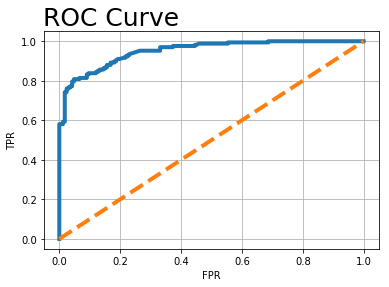

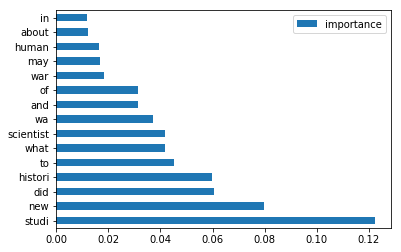

In [20]:
# Gradient Boost
gb_params = {
    'n_estimators': [70],#[60, 70, 80],
    'learning_rate': [.5],#[.1, .25, .5, 1, 2],
    'max_depth': [4],
    'min_samples_split': [3],
}

all_results, all_params, confusion, gb_best_model = fit_model(GradientBoostingClassifier(), 'Gradient Boost', gb_params, all_results, all_params)

# Plot ROC Curve with make_roc function
make_roc(y_test, gb_best_model)

# plot important features
feat_importance = pd.DataFrame(gb_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

## AdaBoost

,AdaBoost
Test score,0.898
Train score,0.843
Sensitivity,0.838
Specificity,0.958
Precision,0.952


/Users/zachgreen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Parameters
AdaBoost,"{'learning_rate': 0.25, 'n_estimators': 150}"


,Act. Positive,Act. Negative,Total
Pred. Positive,42.0%,2.1%,147
Pred. Negative,8.1%,47.7%,186
Total,167,166,333


Runtime:  0.138  minutes


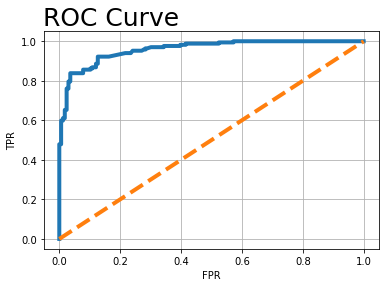

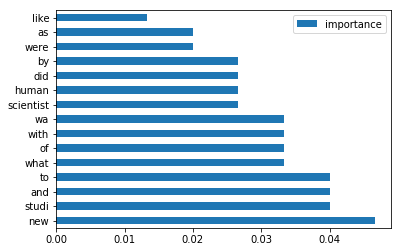

In [21]:
# Adaboost
ada_params = {
    'n_estimators': [150],#[60, 70, 80, 100, 150],
    'learning_rate': [.25]#[.25, .5, 1],
}

all_results, all_params, confusion, ada_best_model = fit_model(AdaBoostClassifier(), 'AdaBoost', ada_params, all_results, all_params)

# Plot ROC Curve with make_roc function
make_roc(y_test, ada_best_model)

# plot important features
feat_importance = pd.DataFrame(ada_best_model.feature_importances_, X_train.columns, columns=['importance'])
feat_importance.sort_values('importance', ascending=False).head(15).plot(kind='barh')

# Overall Results <hr>

In [23]:
# Display scores from all models
display(all_results.tail())

# Show which parameters worked best
display(all_params)

# Calculate how long it took to run
run_end = time.time()
print('Runtime: ', round((run_end - run_start)/60, 3), ' minutes')

,Naive Bayes,Logistic,SVM,KNN,Random Forest,Extra Trees,Gradient Boost,AdaBoost
Precision,0.912,0.961,0.956,0.939,0.938,0.961,0.925,0.952
Sensitivity,0.928,0.892,0.904,0.826,0.82,0.886,0.808,0.838
Specificity,0.91,0.964,0.958,0.946,0.946,0.964,0.934,0.958
Test score,0.919,0.928,0.931,0.886,0.883,0.925,0.871,0.898
Train score,0.885,0.926,0.931,0.883,0.881,0.892,0.859,0.843


,Parameters
Naive Bayes,{'priors': None}
Logistic,"{'C': 25, 'penalty': 'l2'}"
SVM,"{'C': 1.2, 'kernel': 'linear'}"
KNN,"{'metric': 'minkowski', 'n_neighbors': 75, 'p': 2, 'weights': 'distance'}"
Random Forest,"{'bootstrap': False, 'max_features': 46, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 75}"
Extra Trees,"{'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 75}"
Gradient Boost,"{'learning_rate': 0.5, 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 70}"
AdaBoost,"{'learning_rate': 0.25, 'n_estimators': 150}"


Runtime:  5.018  minutes
